# QC and processes raw barcode counts from both library 1 and 2 with the Polylinker
This notebook takes raw barcode counts and processes it into activity scores for each replicate. Due to the low expression of a large fraction of the libraries, including the scrambled sequences and basal construct, we cannot process the library with the same statistical rigor as we did with the Rho promoter. There are three biological replicates of RNA and one DNA replicate of the input plasmid pool.

In [1]:
import os
import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import stats

sys.path.insert(0, "utils")
import modeling, plot_utils, quality_control

In [2]:
plot_utils.set_manuscript_params()

## Load in data

In [3]:
barcode_count_dir = os.path.join(os.getcwd(), "Data", "Polylinker")
l1_barcode_count_files = ["library1Plasmid.counts", "library1Rna1.counts",
                          "library1Rna2.counts", "library1Rna3.counts"]
l2_barcode_count_files = ["library2Plasmid.counts", "library2Rna1.counts",
                          "library2Rna2.counts", "library2Rna3.counts"]

l1_barcode_count_files = [os.path.join(barcode_count_dir, i) for i in l1_barcode_count_files]
l2_barcode_count_files = [os.path.join(barcode_count_dir, i) for i in l2_barcode_count_files]

sample_labels = np.array(["DNA", "RNA1", "RNA2", "RNA3"])
sample_rna_mask = np.array([False, True, True, True])
rna_labels = sample_labels[sample_rna_mask]
dna_labels = sample_labels[np.logical_not(sample_rna_mask)]
n_samples = len(sample_labels)
n_rna_samples = len(rna_labels)
n_dna_samples = len(dna_labels)

n_barcodes_per_sequence = 3
results_dir = barcode_count_dir
l1_output_prefix = os.path.join(results_dir, "library1")
l2_output_prefix = os.path.join(results_dir, "library2")

# Read in and join data
all_sample_counts_l1_df = quality_control.read_bc_count_files(l1_barcode_count_files, sample_labels)
all_sample_counts_l1_df.to_csv(f"{l1_output_prefix}RawBarcodeCounts.txt", sep="\t", na_rep="NaN")
all_sample_counts_l2_df = quality_control.read_bc_count_files(l2_barcode_count_files, sample_labels)
all_sample_counts_l2_df.to_csv(f"{l2_output_prefix}RawBarcodeCounts.txt", sep="\t", na_rep="NaN")
all_sample_counts_l2_df.head(20)

,label,DNA,RNA1,RNA2,RNA3
barcode,,,,,
AACAACAAG,chr7-141291911-141292075_UPPP_MUT-allCrxSites,3,20,15,21
AACAACGTT,chr19-16380352-16380516_CPPN_MUT-allCrxSites,990,10,9,10
AACAACTAC,chr1-44147572-44147736_UPPP_MUT-allCrxSites,1056,2,4,3
AACAACTCG,chr12-116230818-116230982_CPPE_WT,7,4,6,0
AACAACTGT,chr5-65391346-65391510_CPPP_MUT-allCrxSites,1653,1441,9,4695
AACAAGCTT,chr15-97965790-97965954_CPPP_MUT-allCrxSites,4,0,1,2
AACAAGGCG,chr1-59164069-59164233_CPPE_WT,628,2209,3159,880
AACAAGTAG,chr2-158513919-158514083_CPPE_WT,829,2382,3225,2807
AACAAGTCT,chr11-58097684-58097848_UPCP_MUT-allCrxSites,2491,1,1,1


## Threshold barcode counts, assess reproducibility
First we will remove DNA barcodes that are below the cutoff. After RPM normalization, we remove RNA barcodes that are missing in any replicate.

Barcodes missing in DNA:
Sample DNA: 1722 barcodes
1722 barcodes are missing from more than 0 DNA samples.
Barcodes off in RNA:
Sample RNA1: 0 barcodes
Sample RNA2: 0 barcodes
Sample RNA3: 0 barcodes
0 barcodes are off in more than 0 RNA samples.
There are a total of  92.122 million barcode counts.
Barcodes missing in DNA:
Sample DNA: 0 barcodes
0 barcodes are missing from more than 0 DNA samples.
Barcodes off in RNA:
Sample RNA1: 5842 barcodes
Sample RNA2: 11412 barcodes
Sample RNA3: 9805 barcodes
12991 barcodes are off in more than 0 RNA samples.
Barcodes missing in DNA:
Sample DNA: 2107 barcodes
2107 barcodes are missing from more than 0 DNA samples.
Barcodes off in RNA:
Sample RNA1: 0 barcodes
Sample RNA2: 0 barcodes
Sample RNA3: 0 barcodes
0 barcodes are off in more than 0 RNA samples.
There are a total of  89.662 million barcode counts.
Barcodes missing in DNA:
Sample DNA: 0 barcodes
0 barcodes are missing from more than 0 DNA samples.
Barcodes off in RNA:
Sample RNA1: 12647 barc

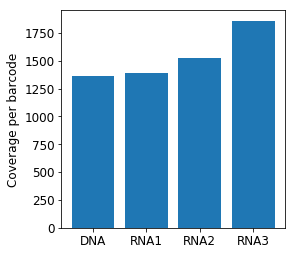

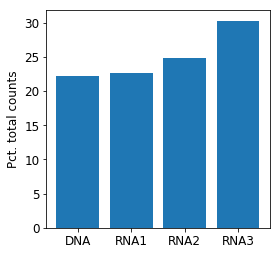

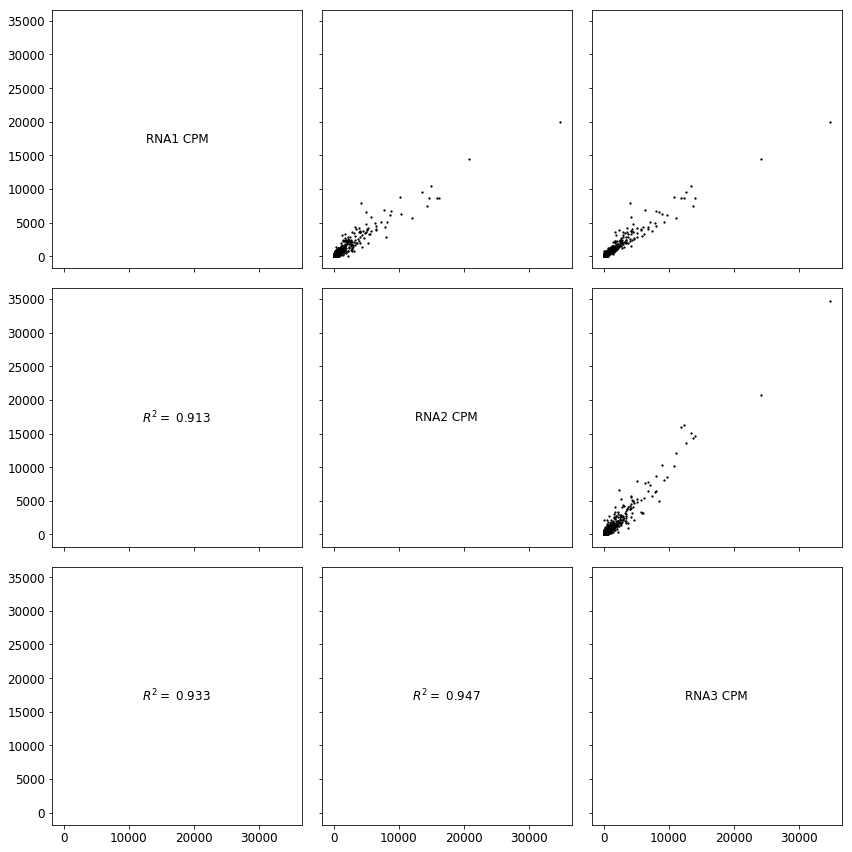

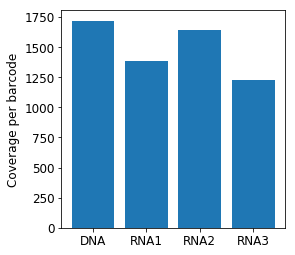

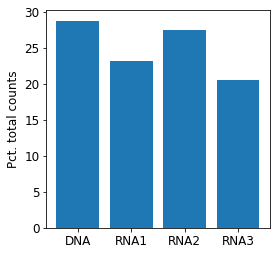

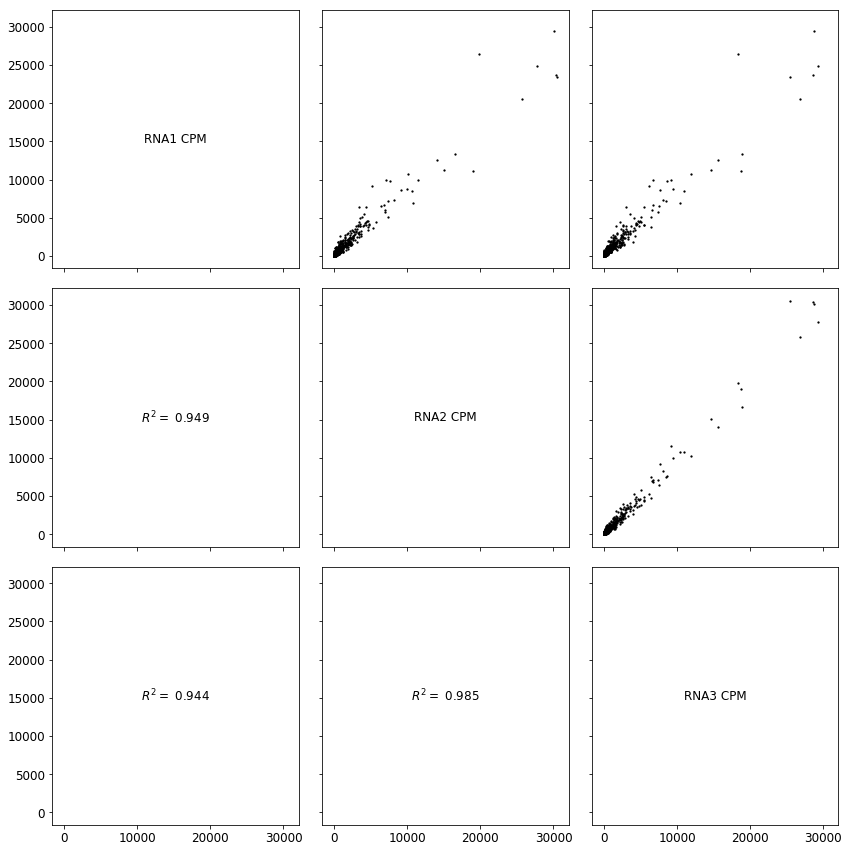

In [4]:
cutoffs_dna_only = [50, 0, 0, 0]
cutoffs_rna_cpm = [0, 8, 8, 8]

# L1
# First remove missing DNA counts and RPM normalize
threshold_l1_sample_counts_df = quality_control.filter_low_counts(all_sample_counts_l1_df, sample_labels, cutoffs_dna_only, dna_labels=dna_labels, bc_per_seq=n_barcodes_per_sequence)
# Now use the same function to remove low abundance RNA barcodes. Since we already RPM normalized, set `cpm_normalize` to False.
threshold_l1_sample_counts_df = quality_control.filter_low_counts(threshold_l1_sample_counts_df, sample_labels, cutoffs_rna_cpm, dna_labels=dna_labels, bc_per_seq=n_barcodes_per_sequence, cpm_normalize=False)
fig = quality_control.reproducibility_plots(threshold_l1_sample_counts_df, rna_labels, "CPM", big_dimensions=True)
plot_utils.save_fig(fig, f"{l1_output_prefix}RnaThresholdBarcodeReproducibility", timestamp=False)

# L2
threshold_l2_sample_counts_df = quality_control.filter_low_counts(all_sample_counts_l2_df, sample_labels, cutoffs_dna_only, dna_labels=dna_labels, bc_per_seq=n_barcodes_per_sequence)
threshold_l2_sample_counts_df = quality_control.filter_low_counts(threshold_l2_sample_counts_df, sample_labels, cutoffs_rna_cpm, dna_labels=dna_labels, bc_per_seq=n_barcodes_per_sequence, cpm_normalize=False)
fig = quality_control.reproducibility_plots(threshold_l2_sample_counts_df, rna_labels, "CPM", big_dimensions=True)
plot_utils.save_fig(fig, f"{l2_output_prefix}RnaThresholdBarcodeReproducibility", timestamp=False)

## Normalize RNA barcode counts by plasmid barcode counts

In [5]:
normalized_l1_df = quality_control.normalize_rna_by_dna(threshold_l1_sample_counts_df, rna_labels, dna_labels)
normalized_l1_df = normalized_l1_df.drop(columns=dna_labels)

normalized_l2_df = quality_control.normalize_rna_by_dna(threshold_l2_sample_counts_df, rna_labels, dna_labels)
normalized_l2_df = normalized_l2_df.drop(columns=dna_labels)

## Compute expression across replicates, drop basal

In [6]:
activity_replicate_l1_df = normalized_l1_df.groupby("label").mean().copy()
activity_replicate_l1_df = activity_replicate_l1_df.drop(index="BASAL")
activity_replicate_l1_df.to_csv(f"{l1_output_prefix}ReplicateExpression.txt", sep="\t", na_rep="NaN")

activity_replicate_l2_df = normalized_l2_df.groupby("label").mean().copy()
activity_replicate_l2_df = activity_replicate_l2_df.drop(index="BASAL")
activity_replicate_l2_df.to_csv(f"{l2_output_prefix}ReplicateExpression.txt", sep="\t", na_rep="NaN")

## Average across replicates

In [7]:
sequence_expression_l1_df = activity_replicate_l1_df.apply(lambda x: pd.Series({"expression": x.mean(), "expression_SEM": x.sem()}), axis=1)
sequence_expression_l1_df.to_csv(f"{l1_output_prefix}TotalExpressionSummary.txt", sep="\t", na_rep="NaN")

sequence_expression_l2_df = activity_replicate_l2_df.apply(lambda x: pd.Series({"expression": x.mean(), "expression_SEM": x.sem()}), axis=1)
sequence_expression_l2_df.to_csv(f"{l2_output_prefix}TotalExpressionSummary.txt", sep="\t", na_rep="NaN")